# 学习目标：
- 对多种网络会使用预训练模型
- 学习微调：全部参数更新，但幅度是比较小的
- 学习特征提取：只更新最后全连接层参数

# 注意点：
- 每个模型架构是由差异的，因此没有在所有场景中都可的微调代码样板

# 使用微调和特征提取的步骤：
1. 初始化预训练模型
2. 重组最后一层，使其具有与新数据集类别数相同的输出数
3. 定义优化器需要对模型的那些参数进行更新
4. 训练

# 1、导入包

In [1]:
%matplotlib notebook

from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
torch.__version__, torchvision.__version__

('2.0.1+cu117', '0.15.2+cu117')

# 2、准备训练数据

In [3]:
"""数据增广操作"""
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
"""数据集路径"""
data_dir = 'data/hymenoptera_data'

"""对数据集中的训练集和验证集进行处理"""
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

"""准备训练数据集"""
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

"""统计训练集和验证集数量"""
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

"""定义训练集的标签，['ants', 'bees']"""
class_names = image_datasets['train'].classes

"""定义再GPU上训练"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Initializing Datasets and Dataloaders...")

Initializing Datasets and Dataloaders...


# 3、定义模型
 1. 定义参数更新方法
- 微调
- 特征提取

 2. 定义模型选择和修改方法
 3. 定义模型选择超参数
 4. 实例化模型
- 查看模型结构是否正确
 5. 将模型转到GPU中

In [5]:
"""定义参数更新方法"""
# 默认情况下，加载一个预训练模型的时候，所有参数的requires_grad都是True，就也是可以更新的
# 当我们是微调的情况下时，默认就行
# 但处在特征提取的情况下我们需要一部分参数固定
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
"""定义模型选择和修改方法"""
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 初始化将在次if语句中设置的这些变量、
    # 每个变量都是模型特定的
    
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # 加载预训练模型
        set_parameter_requires_grad(model_ft, feature_extract) # 设置是预训练还是微调，以及对应那些参数需要更新
        num_ftrs = model_ft.fc.in_features # 抽取模型输出层中的input
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # 重新定义最后一层的输入和输出
        input_size = 224  # 定义输入大小
    
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # 处理辅助网络
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # 处理主要网络
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [7]:
"""定义模型选择超参数"""
model_name = "resnet" # 还有resnet alxnet vgg squeezenet densenet inception(googlenet) 等可供选择
num_classes = 2 # 定义自己的数据集需要输出的数：是蚂蚁还是蜜蜂，这两个
feature_extract = True # 定义是使用特征提取还是微调，设置为True的时候，使用特征提取模式，否则是微调模式

In [8]:
"""实例化模型"""
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [84]:
"""打印模型结构看是否有问题"""
print(model_ft) # 输出层是2，没有问题

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [85]:
"""将模型转到GPU中"""
model_ft = model_ft.to(device)

In [86]:
"""查看torchvision中有那些预训练模型的权重"""
all_models = models.list_models()
all_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [87]:
"""手动便利模型中各个结构，并计算可以训练的参数"""
def print_parameters(model):
    cnt = 0
    for name, layer in model.named_children(): # 遍历每一层
        print("layer({}) parameters".format(name))
        for p in layer.parameters():
            print("\t {} has {} parameters".format(p.shape, p.numel()))
            cnt += p.numel() # 将参数数量累加至cnt
    # 最后打印模型总参数数量
    print('The model has %d trainable parameters\n' % (cnt))
print_parameters(model_ft)

layer(conv1) parameters
	 torch.Size([64, 3, 7, 7]) has 9408 parameters
layer(bn1) parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64]) has 64 parameters
layer(relu) parameters
layer(maxpool) parameters
layer(layer1) parameters
	 torch.Size([64, 64, 3, 3]) has 36864 parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64, 64, 3, 3]) has 36864 parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64, 64, 3, 3]) has 36864 parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64, 64, 3, 3]) has 36864 parameters
	 torch.Size([64]) has 64 parameters
	 torch.Size([64]) has 64 parameters
layer(layer2) parameters
	 torch.Size([128, 64, 3, 3]) has 73728 parameters
	 torch.Size([128]) has 128 parameters
	 torch.Size([128]) has 128 parameters
	 torch.Size([128, 128, 3, 3]) has 147456 parameters
	 torch.Size([128]) has 128 parameters
	 torch.Size([12

# 4、定义损失函数和优化器

In [88]:
"""损失函数"""
criterion = nn.CrossEntropyLoss()

# 5、定义参数优化器

In [89]:
"""优化器"""
params_to_update = model_ft.parameters()
print("Params to learn")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

"""观察所有参数都在优化"""
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn
	 fc.weight
	 fc.bias


# 6、定义训练函数

In [90]:
"""训练过程"""
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = [] # 创建一个空列表来储存每个epoch模型的准确率

    best_model_wts = copy.deepcopy(model.state_dict())  # 用来保存训练中取得最好结果时候的模型参数
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 每个epoch都有一个训练和验证过程
        for phase in ['train', 'val']:
            if phase == 'train': # 定义模型是处于训练模式还是验证模式
                model.train() # 训练模式
            else:
                model.eval() # 验证模式
            
            running_loss = 0.0
            running_corrects = 0
            
            # 在一个epoch中迭代数据
            for inputs, labels in dataloaders[phase]:
                #将训练数据转移到gpu中
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad() # 将梯度归零
                
                # 前向传播,并且设置只在训练时进行跟踪
                with torch.set_grad_enabled(phase == 'train'):
                    # 计算模型损失，在验证的时候只考虑最终输出
                    # googlenet中的inception比较特殊，所一这里单独定义一下
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2 # inception中两个损失合并
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1) # 预测的时候取最大概率为预测类
                    
                    # 反向传播并只在训练模式下更新参数
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # 统计每个小批量下的损失和准确度
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # 统计每个epoch（使用玩一整个数据集为一个epoch）下的损失和准确度
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # 打印损失
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 保存性能最好的模型参数
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()
    time_elapsed = time.time() - since
    print('Train complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc : {:4f}'.format(best_acc))
    
    # 加载最好的模型接着训练
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

# 7、训练模型

In [91]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft,
                             num_epochs=5, is_inception=(model_name=="inception"))

Epoch 0/4
----------
train Loss: 0.5764 Acc: 0.6926
val Loss: 0.2820 Acc: 0.8758

Epoch 1/4
----------
train Loss: 0.4733 Acc: 0.7869
val Loss: 0.1885 Acc: 0.9477

Epoch 2/4
----------
train Loss: 0.6021 Acc: 0.7582
val Loss: 0.1651 Acc: 0.9346

Epoch 3/4
----------
train Loss: 0.3385 Acc: 0.8443
val Loss: 0.2766 Acc: 0.8954

Epoch 4/4
----------
train Loss: 0.4603 Acc: 0.8238
val Loss: 0.2465 Acc: 0.9020

Train complete in 0m 9s
Best val Acc : 0.947712


# 8、保存训练结果最好的模型到本地

In [92]:
"""只保留模型的权重，模型的框架不保存，因为保存模型框架在较多情况下可能出错"""
PATH = 'models_save/resnet18_hymenoptera_data.pth'
torch.save(model_ft.state_dict(), PATH)

# 9、可视化训练损失过程

In [17]:
from torch.utils.tensorboard import SummaryWriter


In [18]:

"""使用魔术命令加载tensorboard"""
%load_ext tensorboard 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
  %reload_ext tensorboard

In [11]:
writer = SummaryWriter('runs/pre_train_resnet18')

In [12]:
"""在tensorboard中检查模型"""
dataiter = iter(dataloaders_dict['train'])
images, labels = next(dataiter)

In [13]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

<IPython.core.display.Javascript object>


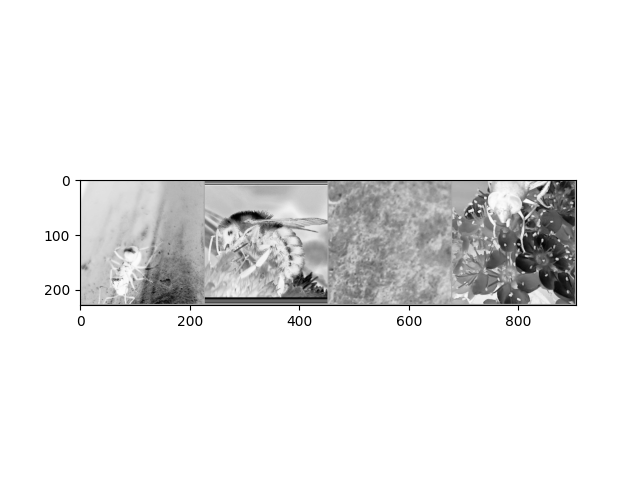

In [14]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [152]:
model_ft = model_ft.to(torch.device('cpu'))
writer.add_graph(model_ft, images)
writer.close()

In [20]:
tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 7972), started 0:08:19 ago. (Use '!kill 7972' to kill it.)